In [2]:
from pyspark.sql import SparkSession, functions as F, DataFrame
from pyspark.sql.functions import col

spark = (
    SparkSession.builder.appName("General Analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/09/12 15:59:28 WARN Utils: Your hostname, Jacks-MacBook-Air-2.local resolves to a loopback address: 127.0.0.1; using 10.12.247.227 instead (on interface en0)
22/09/12 15:59:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/12 15:59:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/09/12 15:59:32 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/09/12 15:59:32 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pyspark.sql.functions as F

### ---------------------------- copied from Outlier.ipynb --------------------------------

In [8]:
data = spark.read.parquet('../data/curated/final_data.parquet')

In [9]:
data = data.withColumn(
    'state',
    F.when(((col('postcode') >= 1000) & (col('postcode') <= 1999)) | ((col('postcode') >= 2000) & (col('postcode') <= 2599)) | ((col('postcode') >= 2619) & (col('postcode') < 2899)) | ((col('postcode') >= 2921) & (col('postcode') < 2999)), 'NSW')\
    .when(((col('postcode') >= 200) & (col('postcode') <= 299)) | ((col('postcode') >= 2600) & (col('postcode') <= 2618)) | ((col('postcode') >= 2900) & (col('postcode') < 2920)), 'ACT')\
    .when(((col('postcode') >= 3000) & (col('postcode') <= 3999)) | ((col('postcode') >= 8000) & (col('postcode') <= 8999)), 'VIC')\
    .when(((col('postcode') >= 4000) & (col('postcode') <= 4999)) | ((col('postcode') >= 9000) & (col('postcode') <= 9999)), 'QLD')\
    .when(((col('postcode') >= 5000) & (col('postcode') <= 5999)), 'SA')\
    .when(((col('postcode') >= 6000) & (col('postcode') <= 6999)), 'WA')\
    .when(((col('postcode') >= 7000) & (col('postcode') <= 7999)), 'TAS')\
    .otherwise('NT')
)
data = data.withColumn(
    'SA2_NAME_2021',
    F.when( (col('state') == 'VIC') & (col('SA2_NAME_2021').isNull()), 'Victoria')\
    .when( (col('state') == 'NSW') & (col('SA2_NAME_2021').isNull()), 'New South Wales')\
    .when( (col('state') == 'QLD') & (col('SA2_NAME_2021').isNull()), 'Queensland')\
    .when( (col('state') == 'NT') & (col('SA2_NAME_2021').isNull()), 'Northern Territory')\
    .when( (col('state') == 'WA') & (col('SA2_NAME_2021').isNull()), 'Western Austraia')\
    .when( (col('state') == 'SA') & (col('SA2_NAME_2021').isNull()), 'South Australia')\
    .when( (col('state') == 'TAS') & (col('SA2_NAME_2021').isNull()), 'Tasmania')\
    .when( (col('state') == 'ACT') & (col('SA2_NAME_2021').isNull()), 'Australian Capital Territory')\
    .otherwise(col('SA2_NAME_2021'))
)

In [10]:
data = data.withColumn("Median_tot_prsnl_inc_weekly", data.Median_tot_prsnl_inc_weekly.cast('float'))
data = data.withColumn("Median_rent_weekly", data.Median_rent_weekly.cast('float'))
data = data.withColumn("Median_mortgage_repay_monthly",data.Median_mortgage_repay_monthly.cast('float'))
data = data.withColumn("Median_age_persons",data.Median_age_persons.cast('float'))
data = data.withColumn("Median_tot_hhd_inc_weekly",data.Median_tot_hhd_inc_weekly.cast('float'))
data = data.withColumn("Average_household_size",data.Average_household_size.cast('float'))
data = data.withColumnRenamed("Completed Year 12", "Completed_Year_12")
data = data.withColumn("Completed_Year_12",data.Completed_Year_12.cast('float'))
data = data.withColumnRenamed("Did Not Attend School", "Did_Not_Attend_School")
data = data.withColumn("Did_Not_Attend_School",data.Did_Not_Attend_School.cast('float'))
data = data.withColumn("TOT_P_P",data.TOT_P_P.cast('float'))


In [11]:
columns = ["Median_tot_prsnl_inc_weekly", "Median_rent_weekly", "Median_mortgage_repay_monthly", "Median_age_persons", "Median_tot_hhd_inc_weekly",\
           "Average_household_size", "Completed_Year_12", "Did_Not_Attend_School", "TOT_P_P"]

for column in columns:
    data = data.withColumn(
        column,
        F.when( (col('SA2_NAME_2021') == 'Northern Territory'), data.groupBy('state').mean(column).collect()[0][1])\
        .when( (col('SA2_NAME_2021') == 'Australian Capital Territory'), data.groupBy('state').mean(column).collect()[1][1])\
        .when( (col('SA2_NAME_2021') == 'South Australia'), data.groupBy('state').mean(column).collect()[2][1])\
        .when( (col('SA2_NAME_2021') == 'Tasmania'), data.groupBy('state').mean(column).collect()[3][1])\
        .when( (col('SA2_NAME_2021') == 'Western Austraia'), data.groupBy('state').mean(column).collect()[4][1])\
        .when( (col('SA2_NAME_2021') == 'Queensland'), data.groupBy('state').mean(column).collect()[5][1])\
        .when( (col('SA2_NAME_2021') == 'Victoria'), data.groupBy('state').mean(column).collect()[6][1])\
        .when( (col('SA2_NAME_2021') == 'New South Wales'), data.groupBy('state').mean(column).collect()[7][1])\
        .otherwise(col(column))
    )

ERROR:root:KeyboardInterrupt while sending command.====>           (8 + 2) / 10]
Traceback (most recent call last):
  File "/Users/jackmelleuish/opt/anaconda3/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/jackmelleuish/opt/anaconda3/lib/python3.9/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/Users/jackmelleuish/opt/anaconda3/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
data = data.na.drop(subset=["postcode"])
data = data[data['dollar_value'] >= 0.05]
data = data.filter(data.Median_mortgage_repay_monthly < 50000.0)
data = data.filter(data.Median_mortgage_repay_monthly < 9999.0)
data = data.filter(data.Average_household_size > 0.0)

In [ ]:
data.write.mode('overwrite').parquet('../data/curated/outlier_data.parquet')

### ---------------------------------------------------------------------------

In [ ]:
# Select attributes to check correlation with transaction amount
df_corr = data.select('dollar_value', 
                      'Median_tot_prsnl_inc_weekly', 
                      'Median_rent_weekly', 
                      'Median_mortgage_repay_monthly', 
                      'Median_age_persons', 
                      'Median_tot_hhd_inc_weekly', 
                      'Average_household_size', 
                      'Completed_Year_12', 
                      'Did_Not_Attend_School').toPandas

In [ ]:
# Create heatmap of correlation
sns.heatmap(df_corr.corr())

In [2]:
joined_data = spark.read.parquet('../data/curated/joined_data.parquet')

In [3]:
joined_data.limit(10)

consumer_id,user_id,merchant_abn,dollar_value,order_id,order_datetime,name,tags,take rate,revenue level,consumer_name,address,state,postcode,gender
561,14108,32709545238,361.7919109492337,7f2cbe00-1d8c-49b...,2021-08-21,Tempor Est Founda...,"[stationery, off...",3.04,c,Zachary Evans,947 Mclaughlin Ra...,NSW,2293,Male
561,14108,19839532017,157.0,01a35e05-f763-4a1...,2021-08-21,Pellentesque Habi...,"[cable, satellit...",4.94,b,Zachary Evans,947 Mclaughlin Ra...,NSW,2293,Male
561,14108,14639489823,217.70536080483546,21ea8392-7fc6-467...,2021-08-21,Auctor Mauris Inc...,"[furniture, home...",6.36,a,Zachary Evans,947 Mclaughlin Ra...,NSW,2293,Male
561,14108,69666829657,178.1273076070476,44a8f7af-113c-4e0...,2021-08-21,Sem Ut Institute,[bicycle shops - ...,2.86,c,Zachary Evans,947 Mclaughlin Ra...,NSW,2293,Male
561,14108,26148653604,15.598745581918507,7a8996c8-220c-41d...,2021-08-21,Volutpat Nulla In...,"[furniture, home...",6.59,a,Zachary Evans,947 Mclaughlin Ra...,NSW,2293,Male
561,14108,29521780474,7.241643588333531,17838284-d80d-400...,2021-08-19,At Sem Corp.,"[cable, satellit...",5.93,a,Zachary Evans,947 Mclaughlin Ra...,NSW,2293,Male
561,14108,43186523025,69.01667749411288,d59a5f33-b131-465...,2021-08-22,Lorem Ipsum Sodal...,[florists supplie...,4.47,b,Zachary Evans,947 Mclaughlin Ra...,NSW,2293,Male
561,14108,46804135891,4.604190891028306,c53d22fe-e476-446...,2021-08-14,Suspendisse Dui C...,"[opticians, opti...",2.93,c,Zachary Evans,947 Mclaughlin Ra...,NSW,2293,Male
561,14108,93429143824,64.54665727026685,9a398824-5d79-441...,2021-08-14,Fames Ac Associates,[lawn and garden ...,1.64,c,Zachary Evans,947 Mclaughlin Ra...,NSW,2293,Male
561,14108,68216911708,13.924604824734638,cae2549d-7585-47c...,2021-08-14,Placerat Eget Ven...,"[computers, comp...",3.05,c,Zachary Evans,947 Mclaughlin Ra...,NSW,2293,Male


In [4]:
revenue_level = joined_data.select('revenue level').toPandas()

In [9]:
# Distribution of revenue levels
rv_count = revenue_level.value_counts(normalize=True, sort=False)
rv_count

revenue level
a                0.448908
b                0.287855
c                0.244261
d                0.010094
e                0.008881
dtype: float64

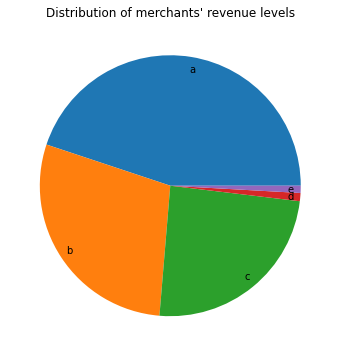

In [15]:
# Plot pie chart for distribution of revenue levels
plt.figure(figsize=(10,6))
plt.pie(rv_count, labels=['a','b','c','d','e'], labeldistance=0.9)
plt.title('Distribution of merchants\' revenue levels')
plt.show()